In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics.pairwise import cosine_similarity

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
def prepare_data_help(path):
  data = np.load(path)

  data = data.transpose((0, 4, 2, 3, 1))
  data = data.reshape(data.shape[0], 15, 15, 2)

  # normalization
  mean = np.mean(data)
  std  = np.std(data)
  data = (data - mean)/(std+1e-7)
  # (N, 15, 15, 2)  -> (N, 15, 15, 1) ; (N, 15, 15, 1)

  return data[:,:,:,:1], data[:,:,:,1:]

def prepare_data(path1, path2):
  # get data
  data1_l, data1_r = prepare_data_help(path1)
  data2_l, data2_r = prepare_data_help(path2)

  data_l = np.array([data1_l, data2_l])
  data_r = np.array([data1_r, data2_r])

  data_l = np.vstack(data_l)
  data_r = np.vstack(data_r)

  return data_l, data_r

In [4]:
path1 = '/content/gdrive/My Drive/data/stereo_matching/cosine_1.npy'
path2 = '/content/gdrive/My Drive/data/stereo_matching/cosine_2.npy'

data_l, data_r = prepare_data(path1, path2)
print(data_l.shape)
print(data_r.shape)

(2000000, 15, 15, 1)
(2000000, 15, 15, 1)


In [5]:
# get labels
Y_neg = np.zeros((1000000, 1))
print(Y_neg.shape)

Y_pos = np.ones((1000000, 1))
print(Y_pos.shape)

# combination
Y = np.array([Y_neg, Y_pos])
Y = np.vstack(Y)
Y = Y.squeeze()
print(Y.shape)

(1000000, 1)
(1000000, 1)
(2000000,)


In [6]:
# shuffle
data_size = data_l.shape[0]

rng = np.random.RandomState(113)
indices = np.arange(data_size)

rng.shuffle(indices)
data_l = data_l[indices]
data_r = data_r[indices]
Y = Y[indices]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization
import tensorflow as tf

# feature network
shared_weights = tf.keras.Sequential([
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform'), 
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform'),
    BatchNormalization() # (N, 1, 1, 32)
])

In [ ]:
def base_model(input_shape):
    inputs_l = tf.keras.layers.Input(shape=input_shape)
    inputs_r = tf.keras.layers.Input(shape=input_shape)
    
    x_l = inputs_l
    x_r = inputs_r    

    # share weights
    x_l = shared_weights(x_l)
    x_r = shared_weights(x_r)

    # combined
    concat_input = tf.keras.layers.Concatenate()
    x = concat_input([x_l, x_r]) 
    
    # metric learning
    x = Conv2D(32, (1,1), activation='relu', kernel_initializer='he_uniform')(x)    
    x = Conv2D(32, (1,1), activation='relu', kernel_initializer='he_uniform')(x)
    x = Conv2D(1, (1,1), activation='sigmoid')(x)
    x = tf.squeeze(x)

    model = Model(inputs=[inputs_l, inputs_r], outputs=x)
    return model

In [ ]:
model = base_model((None, None, 1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 3 56704       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, None, 6 0           sequential[0][0]             

In [ ]:
x_l = tf.random.normal((1, 15, 15, 1))
x_r = tf.random.normal((1, 15, 15, 1))

print(x_l.shape)
print(x_r.shape)

(1, 15, 15, 1)
(1, 15, 15, 1)


In [ ]:
x_l = shared_weights(x_l)
x_r = shared_weights(x_r)

print(x_l.shape)
print(x_r.shape)

# combined
concat_input = tf.keras.layers.Concatenate()
x = concat_input([x_l, x_r]) 
print(x.shape)

(1, 1, 1, 32)
(1, 1, 1, 32)
(1, 1, 1, 64)


In [ ]:
# training
batch_size = 512
epochs = 15

opt_adam = keras.optimizers.Adam()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt_adam)
history = model.fit( (data_l,data_r), Y, batch_size = batch_size, validation_split=0.2, epochs=epochs)

Epoch 1/15
3125/3125 [==============================] - 62s 19ms/step - loss: 0.1085 - val_loss: 0.0068
Epoch 2/15
3125/3125 [==============================] - 60s 19ms/step - loss: 0.0070 - val_loss: 0.0123
Epoch 3/15
3125/3125 [==============================] - 60s 19ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 4/15
3125/3125 [==============================] - 61s 19ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 5/15
3125/3125 [==============================] - 61s 19ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 6/15
3125/3125 [==============================] - 61s 19ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/15
3125/3125 [==============================] - 61s 19ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 8/15
3125/3125 [==============================] - 61s 19ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 9/15
3125/3125 [==============================] - 61s 19ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 10/15
3125/3125 [==============================] - 61s 19m

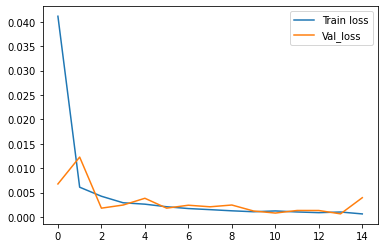

In [ ]:
# Plot the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.legend()

In [ ]:
#Save model to cosin.h5 file
model.save('/content/gdrive/My Drive/data/stereo_matching/model_shared_weight.h5')